<a href="https://colab.research.google.com/github/Bryce-R/ML/blob/master/HybridCEoffsetDecoderTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import math

# set random seed
random.seed(42)
torch.manual_seed(42)

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class SimpleDecoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_classes, nhead=1, num_layers=3):
        super().__init__()
        self.model_dim = model_dim

        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=model_dim,
            nhead=nhead,
            dim_feedforward= 4 * model_dim,
            activation='gelu'
        )
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.class_head = nn.Linear(model_dim, num_classes)
        self.offset_head = nn.Linear(model_dim, 1)

    def generate_causal_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask.to(next(self.parameters()).device)

    def generate_limited_history_causal_mask(self, sz, max_history):
        # Start with a full mask: True = mask, False = keep
        mask = torch.ones(sz, sz, dtype=torch.bool)

        for i in range(sz):
            # Allow looking back up to max_history steps (including self)
            start = max(0, i - max_history + 1)
            mask[i, start:i+1] = False  # Allow attention to history window

        return mask.to(next(self.parameters()).device)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        x_embed = self.input_proj(x)
        x_embed = self.positional_encoding(x_embed)
        x_embed = x_embed.transpose(0, 1)

        # causal_mask = self.generate_causal_mask(seq_len)
        max_history = 20
        causal_mask = self.generate_limited_history_causal_mask(seq_len, max_history)

        # h = self.transformer(x_embed, x_embed, tgt_mask=causal_mask)
        h = self.transformer(x_embed, memory=x_embed, tgt_mask=causal_mask, tgt_is_causal=True)

        h = h.transpose(0, 1)

        class_logits = self.class_head(h)
        offset_preds = self.offset_head(h)

        return class_logits, offset_preds.squeeze(-1)

    def generate(self, initial_sequence, max_new_tokens):
        """
        Generates a sequence of new velocity tokens autoregressively.

        Args:
            initial_sequence: Tensor, the starting sequence of shape (1, initial_seq_len, input_dim).
                              Batch size MUST be 1 for this simple generation loop.
            max_new_tokens: The maximum number of tokens to generate.
            device: The device to perform generation on.

        Returns:
            Tensor, the full generated sequence (initial + new tokens), shape (1, initial_seq_len + max_new_tokens, input_dim).
        """
        device = torch.device("cpu")
        self.eval() # Set model to evaluation mode
        with torch.no_grad(): # Disable gradient calculations
            # Ensure initial sequence is on the correct device
            generated_sequence = initial_sequence.to(device)

            for _ in range(max_new_tokens):
                current_seq_len = generated_sequence.size(1)

                # Check if adding another token would exceed max_seq_len (if PositionalEncoding has a hard limit)
                # This model's PE handles up to max_len=5000, so check against that or your model's limit.
                # You might want to add a check here:
                # if current_seq_len >= self.positional_encoding.pe.size(1):
                #     print("Warning: Generated sequence length exceeds max_seq_len. Stopping generation.")
                #     break

                # Pass the current sequence through the model
                # output_preds.shape: (1, current_seq_len)
                output_preds = self(generated_sequence) # Call the forward method

                # Get the prediction for the last token (this is the prediction for the *next* token)
                # next_token_prediction.shape: (1,)
                next_token_prediction = output_preds[:, -1]

                # Prepare the predicted token to be appended to the sequence
                # The input_dim for the next step needs to be constructed.
                # Assuming input_dim=1 and the input feature is just the velocity itself.
                if self.input_dim == 1:
                     # next_token_input.shape: (1, 1, 1) -> (Batch=1, Seq=1, Feature=1)
                     next_token_input = next_token_prediction.unsqueeze(1).unsqueeze(2)
                else:
                     # If input_dim > 1, you need logic here to create the input features for the next step.
                     # E.g., next_token_input = torch.zeros(1, 1, self.input_dim, device=device)
                     #       next_token_input[0, 0, 0] = next_token_prediction # Place velocity in a specific feature index
                     # This part is problem-dependent! For simplicity, we raise an error or assume input_dim=1.
                     raise NotImplementedError("Generation for input_dim > 1 requires defining how the next input features are constructed.")


                # Append the new token to the sequence
                # generated_sequence.shape changes from (1, L, input_dim) to (1, L+1, input_dim)
                generated_sequence = torch.cat([generated_sequence, next_token_input], dim=1)

            return generated_sequence

In [3]:
def generate_velocity_sequence(seq_length):
    sequence = []
    velocity = 6.0
    state = 'up'  # 'up', 'down', 'stop'
    stop_counter = 0

    for _ in range(seq_length):
        if state == 'up':
            velocity += 0.5
            if velocity >= 10.0:
                velocity = 10.0
                state = 'down'
        elif state == 'down':
            velocity -= 0.8
            if velocity <= 0.0:
                velocity = 0.0
                state = 'stop'
                stop_counter = 0
        elif state == 'stop':
            stop_counter += 1
            if stop_counter >= 2:
                state = 'up'

        sequence.append([velocity])

    return torch.tensor(sequence, dtype=torch.float32)

def plot_sequence(sequence):
    velocity = sequence[:, 0]
    time = torch.arange(sequence.size(0)) * 0.5

    plt.figure(figsize=(10, 4))
    plt.plot(time, velocity, label='Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity')
    plt.title('Velocity over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


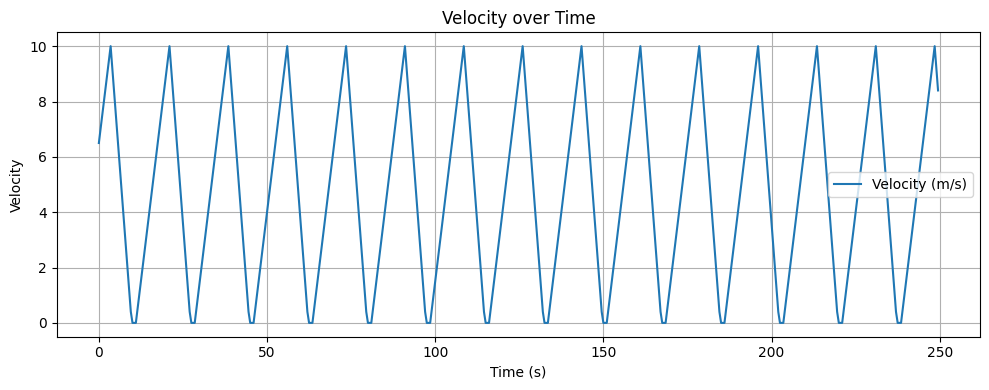

torch.Size([1, 500, 1])


In [20]:
x = generate_velocity_sequence(500).unsqueeze(0)  # Single sequence of length 50
# Plot the sequence
plot_sequence(x[0])
print(x.shape)

torch.Size([1, 500])


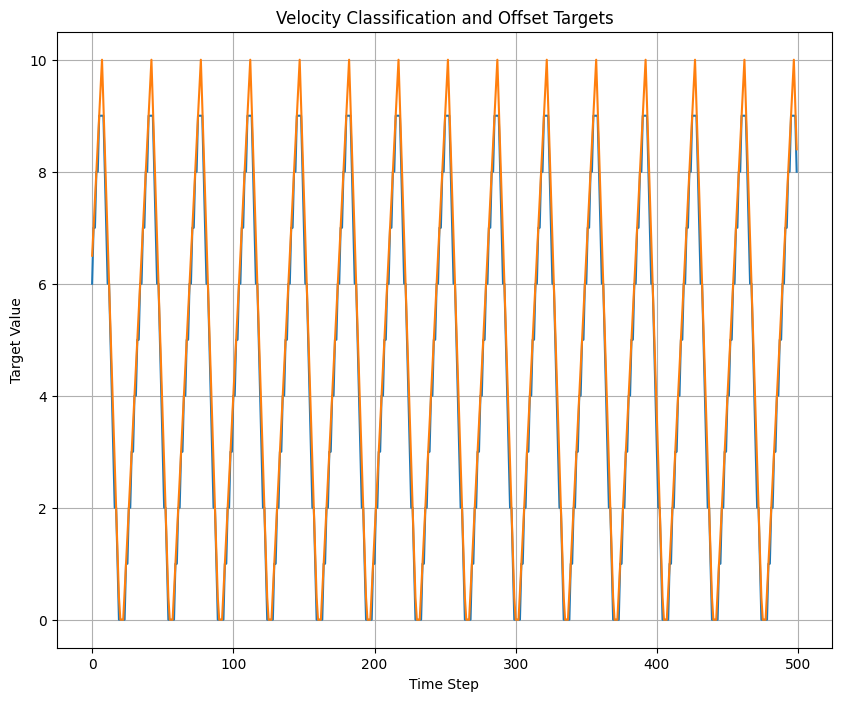

tensor([[[ 6.5000],
         [ 7.0000],
         [ 7.5000],
         [ 8.0000],
         [ 8.5000],
         [ 9.0000],
         [ 9.5000],
         [10.0000],
         [ 9.2000],
         [ 8.4000]]])
tensor([[7, 7, 8, 8, 9, 9, 9, 9, 8, 7]])
tensor([[-0.5000,  0.0000, -0.5000,  0.0000, -0.5000,  0.0000,  0.5000, -0.3000,
         -0.1000,  0.1000]])


In [21]:
num_classes = 10

# def velocity_to_class(velocity, num_classes, min_v=0.0, max_v=10.0):
#     bucket_size = (max_v - min_v) / num_classes
#     return torch.clamp((velocity - min_v) / bucket_size, 0, num_classes - 1).long()

# def class_to_velocity(class_idx, num_classes, min_v=0.0, max_v=10.0):
#     bucket_size = (max_v - min_v) / num_classes

def create_targets(velocity_seq, num_classes, min_v=0.0, max_v=10.0):
    bucket_size = (max_v - min_v) / num_classes
    class_targets = ((velocity_seq.squeeze(-1) - min_v) / bucket_size).long().clamp(0, num_classes - 1)
    bucket_centers = min_v + (class_targets.float() + 0.5) * bucket_size
    offset_targets = velocity_seq.squeeze(-1) - bucket_centers
    return class_targets, offset_targets

# plot targets on
true_classes, true_offsets = create_targets(x, num_classes)
print(true_classes.shape)
plt.figure(figsize=(10, 8))
plt.plot(true_classes[0,:], label='Class Targets')
plt.plot(x[0,:,0], label='Velocity')
# plt.plot(true_offsets, label='Offset Targets')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.title('Velocity Classification and Offset Targets')
# plt.legend()
plt.grid(True)
plt.show()

print(x[:,:10,:])
print(true_classes[:,1:11])
print(true_offsets[:,1:11])

In [25]:
# Example usage:
# Training setup
input_dim = 1
model_dim = 32


model = SimpleDecoderOnlyTransformer(input_dim, model_dim, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 500

true_classes, true_offsets = create_targets(x, num_classes)
true_classes = true_classes[:, 1:]
true_offsets = true_offsets[:, 1:]

max_history = 10
model.train()

block_size = 20
print("x.shape: " + str(x.shape))
print("true_classes.shape: " + str(true_classes.shape))
print("true_offsets.shape: " + str(true_offsets.shape))

# need a get batch function
def get_batch(x, true_classes, true_offsets, batch_size):
    indices = torch.randint(0, x.size(1) - block_size-1, (batch_size,))
    x_batch = torch.stack([x[0, idx:idx+block_size, :] for idx in indices])
    true_classes_batch = torch.stack([true_classes[0, idx+1:idx+block_size+1] for idx in indices])
    true_offsets_batch = torch.stack([true_offsets[0, idx+1:idx+block_size+1] for idx in indices])
    true_targets = torch.stack([x[0, idx+1:idx+block_size+1, :] for idx in indices])
    # print(x_batch.shape, true_classes_batch.shape, true_offsets_batch.shape, true_targets.shape)
    return x_batch, true_classes_batch, true_offsets_batch, true_targets


for epoch in range(num_epochs):

    optimizer.zero_grad()
    x_batch, target_cls_batch, target_offsets, true_targets = get_batch(x, true_classes, true_offsets, 10)
    B, seqlen, _ = x_batch.shape
    # only train until max_history
    class_logits, offset_preds = model(x_batch[:,:,:])
    # print("class_logits.shape: ", class_logits.shape)
    # print("offset_preds.shape: ", offset_preds.shape)
    class_loss = F.cross_entropy(class_logits.view(-1, num_classes), target_cls_batch.view(-1))
    offset_loss = F.mse_loss(offset_preds, target_offsets)

    loss = class_loss + offset_loss
    loss.backward()
    optimizer.step()

    # check the loss of class + offset
    output = F.softmax(class_logits, dim=-1)
    predicted_class = torch.argmax(output, dim=-1)
    predicted_offset = offset_preds
    predicted_velocity = (predicted_class.float()+0.5 + predicted_offset)
    # print("predicted_velocity.shape", predicted_velocity.shape)
    mse_loss = F.mse_loss(predicted_velocity, true_targets.squeeze(-1))


    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, MSE Loss: {mse_loss.item():.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, CE Loss: {class_loss.item():.4f}, MSE Loss: {offset_loss.item():.4f}")



x.shape: torch.Size([1, 500, 1])
true_classes.shape: torch.Size([1, 499])
true_offsets.shape: torch.Size([1, 499])
Epoch 10/500, MSE Loss: 14.9190
Epoch 10/500, Loss: 2.4525, CE Loss: 2.3440, MSE Loss: 0.1085
Epoch 20/500, MSE Loss: 21.6232
Epoch 20/500, Loss: 2.3610, CE Loss: 2.2583, MSE Loss: 0.1027
Epoch 30/500, MSE Loss: 22.8516
Epoch 30/500, Loss: 2.3296, CE Loss: 2.2361, MSE Loss: 0.0934
Epoch 40/500, MSE Loss: 32.5507
Epoch 40/500, Loss: 2.4177, CE Loss: 2.3172, MSE Loss: 0.1005
Epoch 50/500, MSE Loss: 19.2929
Epoch 50/500, Loss: 2.3343, CE Loss: 2.2403, MSE Loss: 0.0941
Epoch 60/500, MSE Loss: 6.4381
Epoch 60/500, Loss: 2.1700, CE Loss: 2.0831, MSE Loss: 0.0869
Epoch 70/500, MSE Loss: 5.3548
Epoch 70/500, Loss: 1.9489, CE Loss: 1.8543, MSE Loss: 0.0946
Epoch 80/500, MSE Loss: 4.3652
Epoch 80/500, Loss: 1.8719, CE Loss: 1.7742, MSE Loss: 0.0977
Epoch 90/500, MSE Loss: 6.9624
Epoch 90/500, Loss: 1.8673, CE Loss: 1.7711, MSE Loss: 0.0962
Epoch 100/500, MSE Loss: 2.5480
Epoch 100/5

In [26]:
# start from [5], use this transformer to generate a sequence length of 100
# model = SimpleDecoderOnlyTransformer(input_dim, model_dim, num_classes)

test_x = torch.tensor([[6.5]], dtype=torch.float32).unsqueeze(0)

generated_sequence = model.generate(test_x, 100)
print(generated_sequence)
plot_sequence(generated_sequence[0])

TypeError: tuple indices must be integers or slices, not tuple

torch.Size([1, 10, 10]) torch.Size([1, 10])
tensor([[[ 6.5000],
         [ 7.0000],
         [ 7.5000],
         [ 8.0000],
         [ 8.5000],
         [ 9.0000],
         [ 9.5000],
         [10.0000],
         [ 9.2000],
         [ 8.4000],
         [ 9.5116]]])


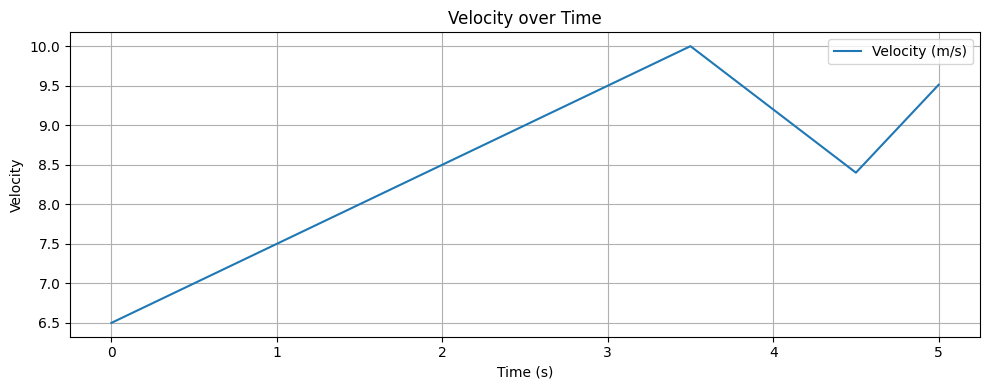

In [18]:
# start from [5], use this transformer to generate a sequence length of 100
# model = SimpleDecoderOnlyTransformer(input_dim, model_dim, num_classes)

# test_x = torch.tensor([[6.5]], dtype=torch.float32).unsqueeze(0)

test_x = x[:,:max_history,:]
# print(test_x)
model.eval()
with torch.no_grad():
    for _ in range(1):
        class_logits, offset_preds = model(test_x)
        print(class_logits.shape, offset_preds.shape)
        # print(class_logits, offset_preds)
        output = F.softmax(class_logits[:, -1, :], dim=-1)
        predicted_class = torch.argmax(output, dim=-1)
        # print(output, predicted_class)
        predicted_offset = offset_preds[:, -1]
        predicted_velocity = (predicted_class.float()+0.5 + predicted_offset)
        test_x = torch.cat([test_x, predicted_velocity.unsqueeze(0).unsqueeze(-1)], dim=1)
        # print(x)
print(test_x)
plot_sequence(test_x[0])
